# Load Data

In [5]:
import seaborn as sns
import re

In [4]:
import pandas as pd

df = pd.read_csv("../data/album_age_ratings.csv")
print ("Columns of df: ",  list(enumerate(df.columns)), "\n")

print ("Shape of df: ", df.shape, "\n")

print ("Number of albums having description: ", df['Description'].notnull().sum(), "\n")

df.head(3)

Columns of df:  [(0, 'Age'), (1, 'Album_Name'), (2, 'Artist'), (3, 'Year'), (4, 'Description'), (5, 'Age Group')] 

Shape of df:  (2206, 6) 

Number of albums having description:  2206 



,Age,Album_Name,Artist,Year,Description,Age Group
0,2,Sesame Street: Halloween Collection,Sesame Street,2012,"Playful, not-so-spooky Halloween songs for th...",Toodler
1,2,A Child's Celebration of Rock 'n' Roll,Various Artists,1996,Songs to get toddlers and teens energized.,Toodler
2,2,Wake up Jeff,The Wiggles,2000,Songs and scenes certain to keep kids attenti...,Toodler


# Text Processing

In [6]:
import spacy
nlp = spacy.load("en", disable=['parser','ner','tagger', 'textcat'])

In [7]:
import re

def my_lemmatizer(doc):
    doc_cleaned = ' '.join(re.findall(r'\b\w[\w\']+\b', doc))
    return [ w.lemma_.lower() for w in nlp(doc_cleaned) 
                      if w.lemma_ not in ['_', '.', '-PRON-'] ]

stopwords = spacy.lang.en.stop_words.STOP_WORDS

stopwords = set(my_lemmatizer(' '.join(list(stopwords))))

# Bag-of-Words Model + K-Mean clustering

In [8]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
max_features = 1000

cv = CountVectorizer(tokenizer=my_lemmatizer, stop_words=stopwords, 
                     min_df=1, max_df=0.9, max_features=max_features)
counts = cv.fit_transform(df['Description'])

tf = TfidfTransformer()
matrix = tf.fit_transform(counts)

In [9]:
import random   
random.sample(list(cv.get_feature_names_out()), 10)    #random select 10 words from CountVectorizer

['leave',
 'invite',
 'orchestral',
 'hero',
 'mj',
 'tedious',
 'harsh',
 'chase',
 'empower',
 'outstanding']

In [10]:
from sklearn.cluster import KMeans
number_of_clusters = 5

kmc_5 = KMeans(n_clusters=number_of_clusters, n_init=3, random_state=117)  # random_state for consistency
kmc_5.fit(matrix)
kmc_5.cluster_centers_
import numpy as np

number_of_top_words = 10

cluster_words = np.argsort(kmc_5.cluster_centers_, axis=1)
terms = cv.get_feature_names_out()

top_words = set()

for i in range(number_of_clusters):
    print('Cluster {}: '.format(i))
    print(' '.join([terms[k] for k in cluster_words[i][-number_of_top_words:]]),'\n')
    top_words = top_words.union([terms[k] for k in cluster_words[i][-number_of_top_words:]])
    
top_words = sorted(list(top_words))

Cluster 0: 
rap fun love country song dance track music tune clean 

Cluster 1: 
soundtrack love message rap sex album cd fun teen song 

Cluster 2: 
movie tune old fun music okay young friendly song kid 

Cluster 3: 
teen kid punk classic roll clean pop indie alt rock 

Cluster 4: 
electro punk tweens country track love song dance clean pop 



In [11]:
word_df = pd.DataFrame(counts.toarray(), columns=terms)[top_words]
word_df['Cluster'] = kmc_5.labels_.tolist()
word_df.sample(3)

,album,alt,cd,classic,clean,country,dance,electro,friendly,fun,...,roll,sex,song,soundtrack,teen,track,tune,tweens,young,Cluster
1036,0,0,0,0,0,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,4
125,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
881,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


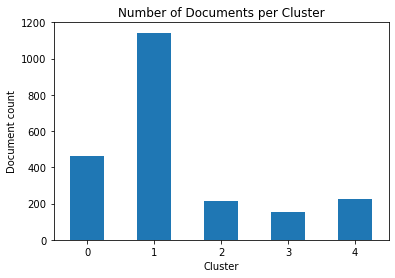

In [12]:
word_df.groupby('Cluster').count()[top_words[0]].\
    plot.bar(rot=0).\
    set(ylabel='Document count',
    title='Number of Documents per Cluster');

# Latent Dirichlet allocation (LDA)

In [20]:
import gensim

import re
def process_words(texts, stop_words=set()):
    result = []
    for t in texts:
        t = ' '.join(re.findall(r'\b\w[\w\']+\b', t))
        doc = nlp(t)
        result.append([token.lemma_.lower() for token in doc if token.lemma_ not in stop_words])
    return result

processed_text = process_words(df['Description'], stop_words=stopwords.union(['-PRON-','song','album','cd','track']))

In [37]:
dictionary = gensim.corpora.Dictionary(processed_text)
print('Number of unique tokens: {}'.format(len(dictionary)))
corpus = [dictionary.doc2bow(t) for t in processed_text]
num_topics = 7

lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus, 
                                            id2word=dictionary,
                                            num_topics=num_topics, 
                                            random_state=117, update_every=1,
                                            chunksize=1500, 
                                            passes=5, iterations=10,
                                            alpha='asymmetric', eta=1/100,
                                            per_word_topics=True)

Number of unique tokens: 2528


In [38]:
from pprint import pprint

pprint(lda_model.print_topics(num_words=5))

[(0,
  '0.029*"clean" + 0.023*"mature" + 0.023*"pop" + 0.021*"kid" + 0.018*"teen"'),
 (1,
  '0.056*"rap" + 0.043*"explicit" + 0.042*"sex" + 0.034*"tune" + 0.026*"cd"'),
 (2,
  '0.055*"debut" + 0.028*"language" + 0.024*"soul" + 0.022*"sound" + '
  '0.020*"sex"'),
 (3,
  '0.069*"hip" + 0.065*"message" + 0.059*"hop" + 0.038*"rock" + 0.036*"band"'),
 (4,
  '0.095*"teen" + 0.086*"ok" + 0.058*"old" + 0.044*"catchy" + 0.037*"tweens"'),
 (5, '0.116*"dance" + 0.096*"pop" + 0.041*"kid" + 0.029*"sexy" + 0.028*"love"'),
 (6,
  '0.074*"iffy" + 0.052*"ballad" + 0.051*"kid" + 0.045*"word" + 0.044*"not"')]


In [23]:
lda_model.get_document_topics(corpus[0])

[(0, 0.07331658),
 (1, 0.54994),
 (2, 0.03516695),
 (3, 0.31768814),
 (4, 0.023888383)]

In [39]:
def get_main_topic_df(model, bow, texts):
    topic_list = []
    percent_list = []
    keyword_list = []
    
    for wc in bow:
        topic, percent = sorted(model.get_document_topics(wc), key=lambda x: x[1], reverse=True)[0]
        topic_list.append(topic)
        percent_list.append(round(percent, 3))
        keyword_list.append(' '.join(sorted([x[0] for x in model.show_topic(topic)])))

    result_df = pd.concat([pd.Series(topic_list, name='Dominant_topic'), 
                           pd.Series(percent_list, name='Percent'), 
                           pd.Series(texts, name='Processed_text'), 
                           pd.Series(keyword_list, name='Keywords')], axis=1)

    return result_df

In [40]:
main_topic_df = get_main_topic_df(lda_model, corpus, processed_text)

main_topic_df.sample(10)

,Dominant_topic,Percent,Processed_text,Keywords
845,0,0.591,"[empowering, mildy, suggestive, electro, pop, ...",cd clean fun kid mature pop rock teen tune well
1731,5,0.413,"[burlesque, dancer, try, sound, like, pop, star]",dance drink hit kid lot love mix pop sexy usual
1602,1,0.674,"[reality, star, lame, focus, money, party]",beat cd club drink explicit party rap sex tune...
178,0,0.853,"[inviting, encourage, listen, rhyme, movement]",cd clean fun kid mature pop rock teen tune well
784,0,0.611,"[teen, talent, feature, mtv, appeal, peer]",cd clean fun kid mature pop rock teen tune well
1351,0,0.421,"[one, perry, clean, despite, iffy, line]",cd clean fun kid mature pop rock teen tune well
889,3,0.766,"[nonsensical, techno, funk, safe, group, past,...",band bite family fun hip hop message music pop...
514,0,0.908,"[more, clean, girl, craziness, young, tween, s...",cd clean fun kid mature pop rock teen tune well
1964,5,0.443,"[sexier, usual, rihanna, single, hot, kid]",dance drink hit kid lot love mix pop sexy usual
885,0,0.570,"[mixed, message, mar, idol, rocker, clean, cd]",cd clean fun kid mature pop rock teen tune well


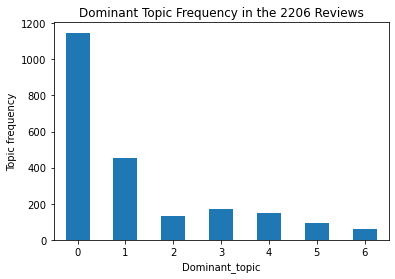

In [41]:
grouped_topics = main_topic_df.groupby('Dominant_topic')
grouped_topics.count()['Processed_text'].\
    plot.bar(rot=0).\
    set(title='Dominant Topic Frequency in the {} Reviews'.format(len(df)),
        ylabel='Topic frequency'); 

In [27]:
representatives = pd.DataFrame()

for k in grouped_topics.groups.keys():
    representatives = pd.concat([ representatives, 
                                 grouped_topics.get_group(k).sort_values(['Percent'], ascending=False).head(1) ])
    
representatives

,Dominant_topic,Percent,Processed_text,Keywords
1279,0,0.933,"[idol, velvet, teddy, bear, offer, clean, gosp...",clean dance fun kid mature music pop rock teen...
1894,1,0.903,"[mc, explore, money, semi, explicit, rap, tune]",cd clean explicit pop profanity rap sex star t...
215,2,0.894,"[sweet, simple, folk, music, kid, sugar, add]",content debut great love musical original pop ...
1199,3,0.903,"[ipod, ad, boost, singer, safe, vocal, pure, p...",bite drink explicit fun hip hop lot message po...
1363,4,0.899,"[breezy, pop, tune, mention, party, ok, old, t...",band catchy indie kid ok old rock sexy teen tw...


In [42]:
import ipywidgets as widgets
from IPython.display import display
from ipywidgets import interact, interactive



def f(idx):
    print('Document: {}  Dominant topic: {}\n'.format(representatives.index[idx], 
                                       representatives.loc[representatives.index[idx]]['Dominant_topic']))
    print(df['Description'][representatives.index[idx]])

    
interactive(f, idx = widgets.Dropdown(options=[0,1,2,3,4], value=0, description='topic id'))

interactive(children=(Dropdown(description='topic id', options=(0, 1, 2, 3, 4), value=0), Output()), _dom_clas…